In [32]:
import os

if(os.getcwd().split('\\')[-1] == 'analytic'):           
    os.chdir('../')
os.getcwd()

'S:\\MSE\\project\\rnd-agent'

In [33]:
from typing import List
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from utlis.io_helper import OsPath
from tensorflow.python.framework import tensor_util
import os
import yaml
import numpy as np
import tensorflow as tf

import seaborn as sns; sns.set()

from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from matplotlib.image import imread

from analytic.tensorboard_helpers import *
from analytic.analytic_helpers import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

## Constants

In [34]:
run = '2020-08-15-19-48'
log_name = run + '--rnd-grayscale'

event_file_0 = OsPath(f"models/{run}/env_eval_instance_0/")
event_file_1 = OsPath(f"models/{run}/env_eval_instance_1/")
event_file_2 = OsPath(f"models/{run}/env_eval_instance_2/")
event_file_3 = OsPath(f"models/{run}/env_eval_instance_3/")

log_folder = OsPath(f"data/{log_name}/")

log_path_0 = log_folder + "eval_0.yaml"
log_path_1 = log_folder + "eval_1.yaml"
log_path_2 = log_folder + "eval_2.yaml"
log_path_3 = log_folder + "eval_3.yaml"

event_files = [event_file_0, event_file_1, event_file_2,event_file_3]
log_paths = [log_path_0, log_path_1, log_path_2, log_path_3]

event_train_file_0 = OsPath(f"models/{run}/env_instance_0/")
event_train_file_1 = OsPath(f"models/{run}/env_instance_1/")
event_train_file_2 = OsPath(f"models/{run}/env_instance_2/")
event_train_file_3 = OsPath(f"models/{run}/env_instance_3/")
event_train_files = [event_train_file_0, event_train_file_1, event_train_file_2, event_train_file_3]


log_path_train_0 = log_folder + "train_0.yaml"
log_path_train_1 = log_folder + "train_1.yaml"
log_path_train_2 = log_folder + "train_2.yaml"
log_path_train_3 = log_folder + "train_3.yaml"

log_paths_train = [log_path_train_0, log_path_train_1, log_path_train_2, log_path_train_3]

data_folder = OsPath("data/test_simple/")

img_left_bottom = np.array([-7.5, -9.9])
img_right_top = np.array([37.2, 8.1])
level_img_path_0 = 'data/TestLevel0.png'
level_img_path_1 = 'data/TestLevel1.png'
level_img_path_2 = 'data/TestLevel2.png'
level_img_path_3 = 'data/TestLevel3.png'
level_img_left = -7.5
level_img_right = 37.2
level_img_bottom = -9.9
level_img_top = 8.1
img0 = imread(level_img_path_0)
img1 = imread(level_img_path_1)
img2 = imread(level_img_path_2)
img3 = imread(level_img_path_3)
imgs = [img0, img1, img2, img3]

## Save to file

In [35]:
for log_path, event_file in zip(log_paths, event_files):
    # if not log_path.exists():
        save(log_path, event_file)

In [36]:
for log_path, event_file in zip(log_paths_train, event_train_files):
    #if not log_path.exists():
    save_train(log_path, event_file)

## load Data

In [37]:
skip_train_steps = 0
skip_eval_steps = 1000

In [38]:
dicts = [load(log_path) for log_path in log_paths]
dfs = [pd.DataFrame(data=d).iloc[skip_eval_steps:] for d in dicts]

df = pd.DataFrame()
for d in dfs:
    df = pd.concat([df, d])

In [39]:
dicts_train = [load(log_path) for log_path in log_paths_train]
dfs_train = [pd.DataFrame(data=d).iloc[skip_train_steps:] for d in dicts_train]

df_train = pd.DataFrame()
for d in dfs_train:
    df_train = pd.concat([df_train, d])

In [41]:
dfs_train[0]

action_0  action_1  curiosity  extrinsic_reward    ix   iy  \
0     0.046726  0.096689   0.363933          0.244455   3.0  4.0   
1     1.596008  1.125859   0.832965          1.062837  41.0  4.0   
2     1.083569  1.472134   0.255623          0.618632  -4.0  1.0   
3     2.118542  0.853631   0.433074          0.127209  67.0  1.0   
4     1.983024  1.333558   0.902012          1.619066  51.0  1.0   
...        ...       ...        ...               ...   ...  ...   
1326  1.461855  2.094736   1.806554          0.764763  81.0  3.0   
1327  1.148033  1.408380   1.680851          0.303737  60.0  3.0   
1328  1.554067  1.524671   2.255933          1.809569  43.0  5.0   
1329  0.936714  2.411536   0.949280          1.372518  24.0  5.0   
1330  1.959209  1.802370   2.483854          1.021110   2.0  4.0   

      total_reward          x         y  
0         0.852842   1.250218  0.707644  
1         2.958639  16.494999  0.844120  
2         1.492887  -1.320002 -0.575000  
3         0.687492  27.182957 -0.575000  
4         4.140145  20.505280 -0.575000  
...            ...        ...       ...  
1326      3.336080  32.483009  0.291736  
1327      2.288324  24.339630  0.465664  
1328      5.875072  17.574989  1.381637  
1329      3.694317   9.647337  1.271800  
1330      4.526073   0.925364  0.792101  

[1331 rows x 9 columns]

# Train

In [46]:
print('mean', df_train['curiosity'].mean())
print('median', df_train['curiosity'].median())
print('std', df_train['curiosity'].std())
print('max', df_train['curiosity'].max())
print('min', df_train['curiosity'].min())

mean 1.2688277783868103
median 1.0949946641921997
std 0.81618167490388
max 9.228900909423828
min 0.0011387428967282176


In [1]:
df_train.hist('curiosity', bins=50)
# plt.title("Histogram of the curiosity")
plt.savefig(str(log_folder + 'hist_train.png'), bbox_inches='tight')
plt.yscale('log')
plt.show()

NameError: name 'df_train' is not defined

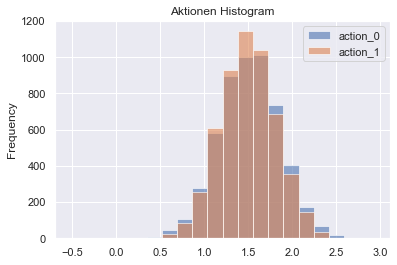

In [42]:
df_train[['action_0', 'action_1']].plot.hist(bins=20, alpha=0.6)
plt.title('Aktionen Histogram')
plt.savefig(str(log_folder + f"action_hists.png"), bbox_inches='tight')
plt.show()

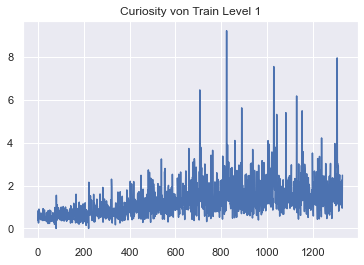

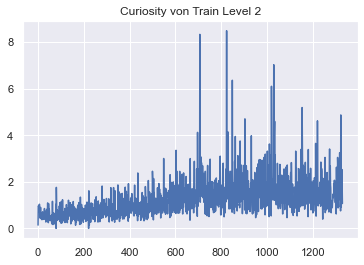

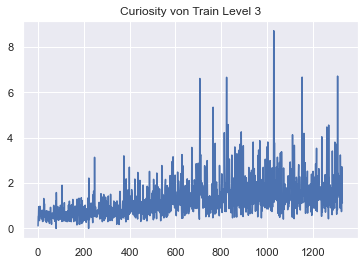

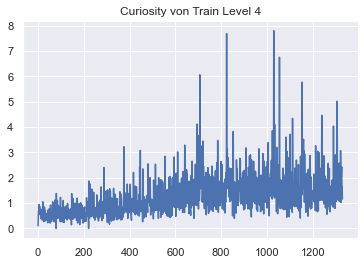

In [43]:
for i, df_t in enumerate(dfs_train):
    df_t.plot(y='curiosity', use_index=True, legend=False)
    plt.title(f"Curiosity von Train Level {i+1}")
    plt.savefig(str(log_folder + f"curiosity_train_{i}.png"), bbox_inches='tight')
    plt.show()

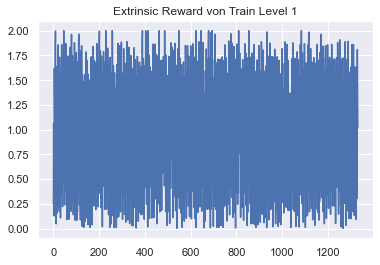

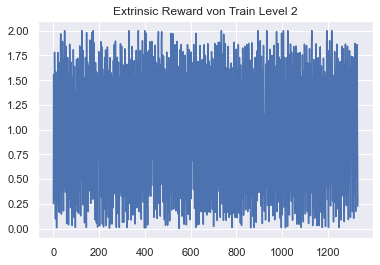

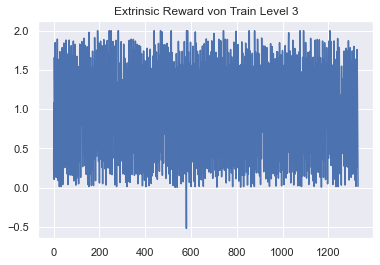

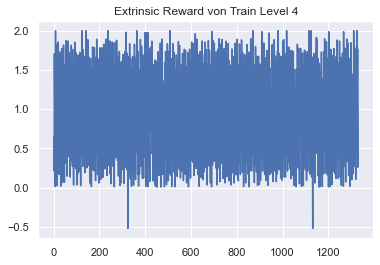

In [44]:
for i, df_t in enumerate(dfs_train):
    df_t[df_t['extrinsic_reward'] > -10].plot(y='extrinsic_reward', use_index=True, legend=False)
    plt.title(f"Extrinsic Reward von Train Level {i+1}")
    plt.savefig(str(log_folder + f"extrinsic_reward_{i}.png"), bbox_inches='tight')
    plt.show()

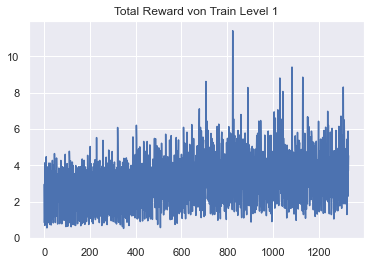

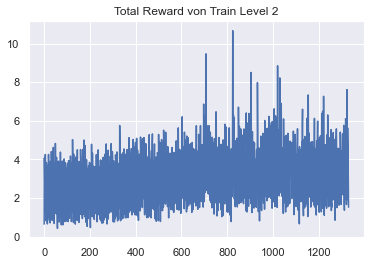

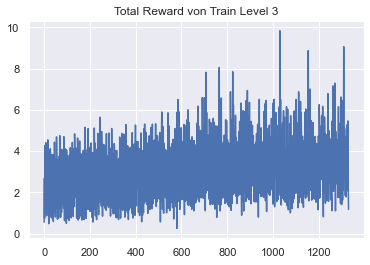

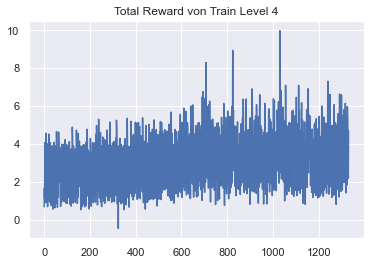

In [45]:
for i, df_t in enumerate(dfs_train):
    df_t.plot(y='total_reward', use_index=True, legend=False)
    plt.title(f"Total Reward von Train Level {i+1}")
    plt.savefig(str(log_folder + f"total_reward_{i}.png"), bbox_inches='tight')
    plt.show()

# Test Level

## Filter out bad runs

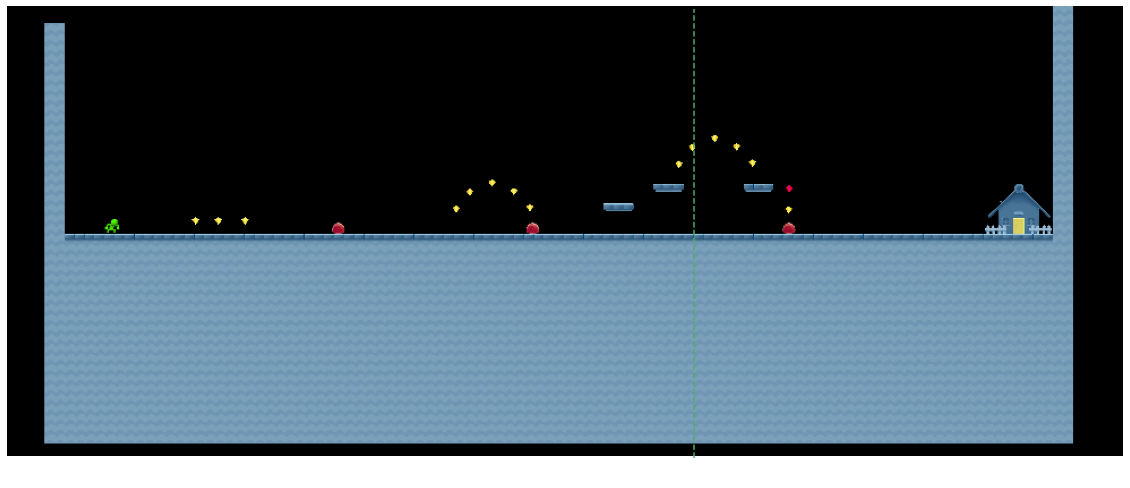

In [12]:
plt.figure(figsize=(20,10))
# plt.scatter([20.0], [0.0])
# plt.title("Minimum erreichte x Koorinaten")
plt.vlines(x=[20.0], ymin=-10, ymax=8, colors='g', linestyles='dashed', label='minimum x wert')
plot_level(img0)
plt.grid(b=None)
plt.axis('off')
plt.savefig(str(log_folder + 'min_x_pos.png'), dpi=300, bbox_inches='tight')
plt.show()

In [13]:
filter = np.zeros(len(dfs[0]), dtype=np.int)

for i in range(len(dfs[0])//1000):
    max_x = -999999
    for d in dfs:
        max_x = max(d.iloc[i*1000:i*1000+1000].x.max(), max_x)
    print(max_x)
    if max_x > 20:
        filter[i*1000:i*1000+1000] = 1

filter = np.array(filter, dtype=bool)
for i in range(len(dfs)):
    dfs[i] = dfs[i][filter]

df = pd.DataFrame()
for d in dfs:
    df = pd.concat([df, d])

32.492950439453125
32.46292495727539
32.46292495727539
32.492950439453125
32.46292495727539
32.508033752441406
32.76300048828125
32.46292495727539
32.492950439453125
32.46292495727539
32.508033752441406
32.76300048828125
32.46292495727539
32.4930305480957
32.46292495727539
32.554527282714844
32.763084411621094
32.46292495727539
32.49311065673828
32.46292495727539
32.4731330871582
32.763160705566406
32.46292495727539
32.493186950683594
32.46292495727539
32.46292495727539
32.46292495727539
32.46292495727539
32.46292495727539
32.46292495727539
32.492950439453125
32.46292495727539
32.508033752441406
32.76300048828125
32.46292495727539
32.4930305480957
32.46292495727539
32.492950439453125
32.46292495727539
32.508033752441406


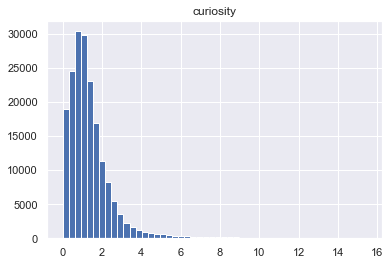

mean 1.3782587929104513
median 1.113133192062378
std 1.2788455644469647
max 15.470348358154297
min 0.00018787174485623837


In [51]:
df.hist('curiosity', bins=50)
# plt.title("Histogram of the curiosity")
plt.savefig(str(log_folder + 'hist.png'), bbox_inches='tight')
plt.show()
print('mean', df.curiosity.mean())
print('median', df.curiosity.median())
print('std', df.curiosity.std())
print('max', df['curiosity'].max())
print('min', df['curiosity'].min())

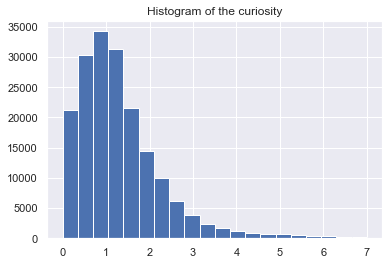

In [49]:
df[df.curiosity < 7].hist('curiosity', bins=20)
plt.title("Histogram of the curiosity")
plt.savefig(str(log_folder + 'hist.png'), bbox_inches='tight')
plt.show()

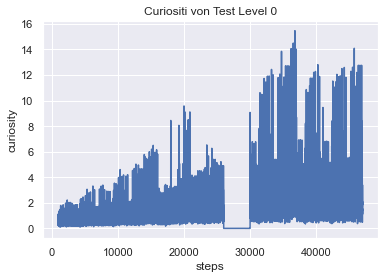

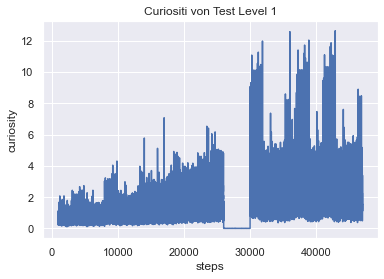

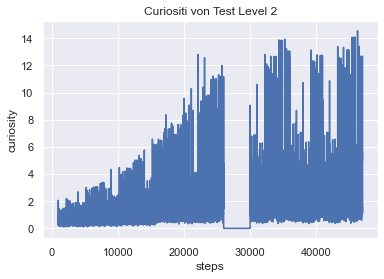

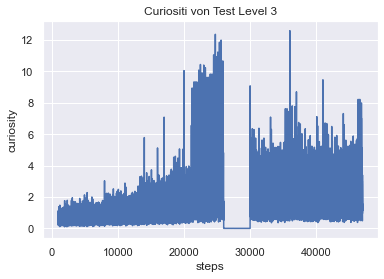

In [50]:
for i, df_instance in enumerate(dfs):
    df_instance.plot(y='curiosity', use_index=True, legend=False)
    plt.xlabel('steps')
    plt.ylabel('curiosity')
    plt.title(f"Curiositi von Test Level {i}")
    plt.savefig(str(log_folder + f"curiosity_over_steps_{i}.png"), bbox_inches='tight')
    plt.show()

## Position Plot

<Figure size 1440x720 with 0 Axes>

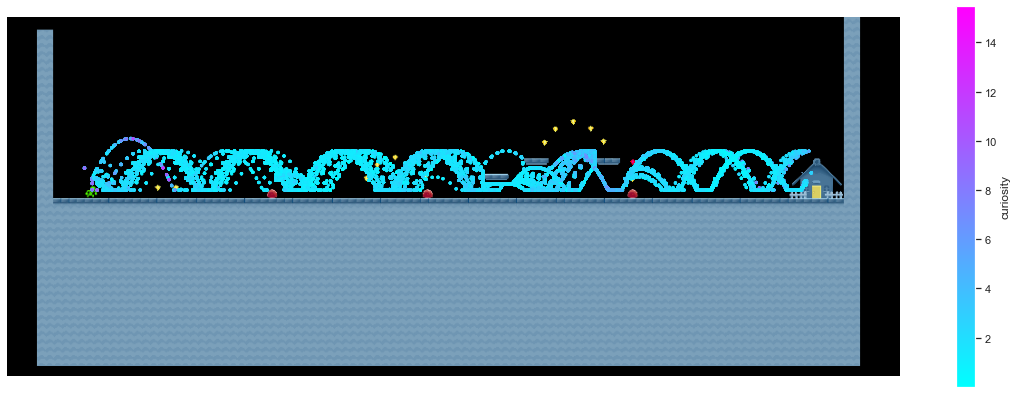

In [52]:
plt.figure(figsize=(20,10))
df.plot.scatter('x', 'y', c='curiosity', s=5, colormap='cool', figsize=(20,7))
plot_level(img0)
plt.grid(b=None)
plt.axis('off')
plt.savefig(str(log_folder + 'position_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

In [53]:
def slider_action(start):
    plot_position_slice(start, start+4000, img3, df)

interact(slider_action, start=widgets.IntSlider(min=0, max=len(df), step=4000, value=0))

interactive(children=(IntSlider(value=0, description='start', max=184000, step=4000), Output()), _dom_classes=…

<function __main__.slider_action(start)>

## Only hight curiosity

count: 278


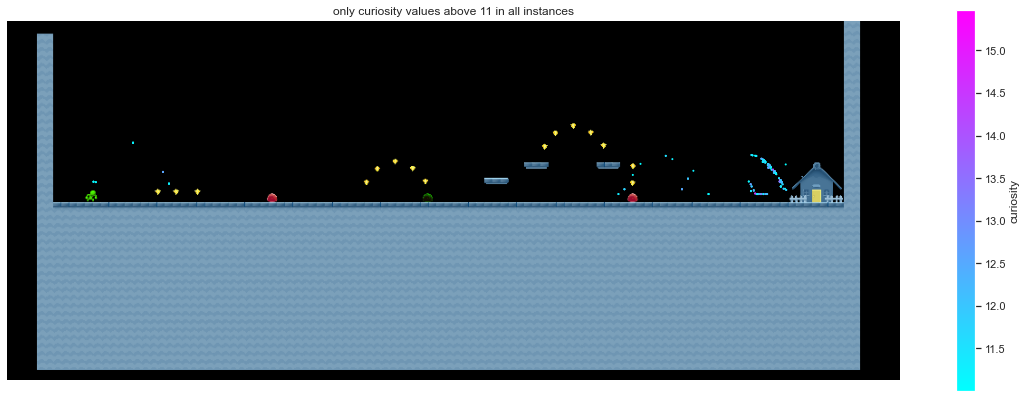

       curiosity    ix   iy          x         y
36774  15.470348  77.0  3.0  30.932734  0.569729
46238  14.562169  74.0  1.0  29.949501 -0.547782
36525  14.501159  74.0  5.0  29.980368  1.328429
45876  14.093143  77.0  3.0  30.902641  0.569729
45746  14.093143  77.0  3.0  30.902924  0.569729
45616  14.093143  77.0  3.0  30.902641  0.569729
45370  14.059832  77.0  4.0  30.842644  0.647777
36276  14.057464  77.0  3.0  30.993021  0.444669
36651  14.057464  77.0  3.0  30.993027  0.444660
36153  14.045315  77.0  3.0  30.902924  0.569729


In [54]:
threshold = 11

def create_hight_curiosity_plot(data_frame: pd.DataFrame, name: str, ax: plt.Axes = None, figsize=(20,7), size=1) -> plt.Axes:
    return data_frame.plot.scatter('x', 'y', c='curiosity', colormap='cool', s=size, figsize=figsize, 
                                   title=f"only curiosity values above {threshold} in {name}", ax=ax)

df_hight_curiosity = df[df.curiosity > threshold]
print('count:', len(df_hight_curiosity))
create_hight_curiosity_plot(df_hight_curiosity, 'all instances')
plot_level(img1)
disable_grid_and_axis()
plt.savefig(str(log_folder + 'best_curiosity_plot.png'), dpi=300, bbox_inches='tight')
plt.show()
df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)
print(df_sorted.iloc[:10])

## For each Instance

114


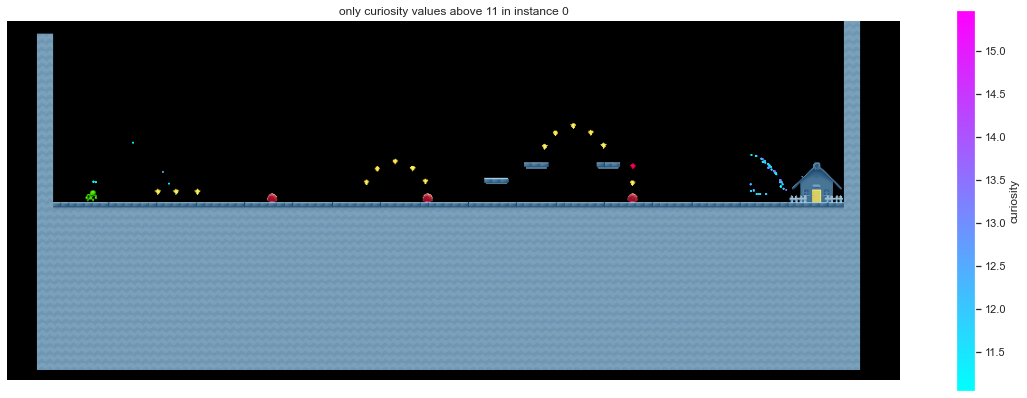

23


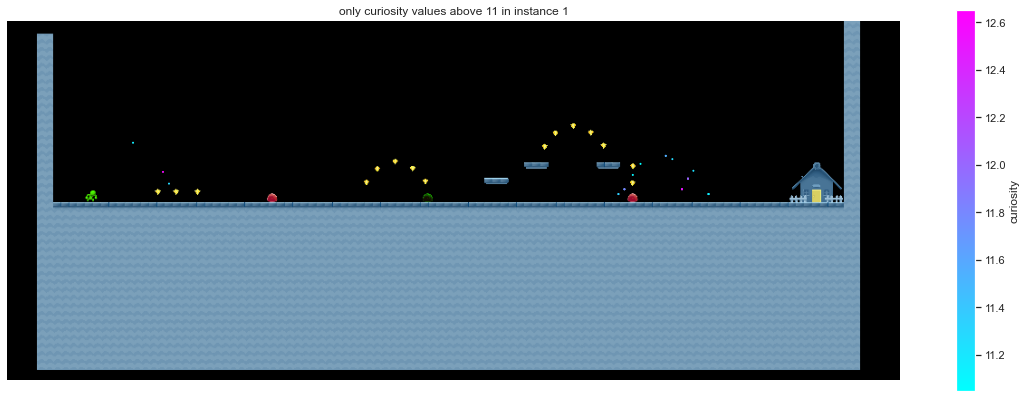

129


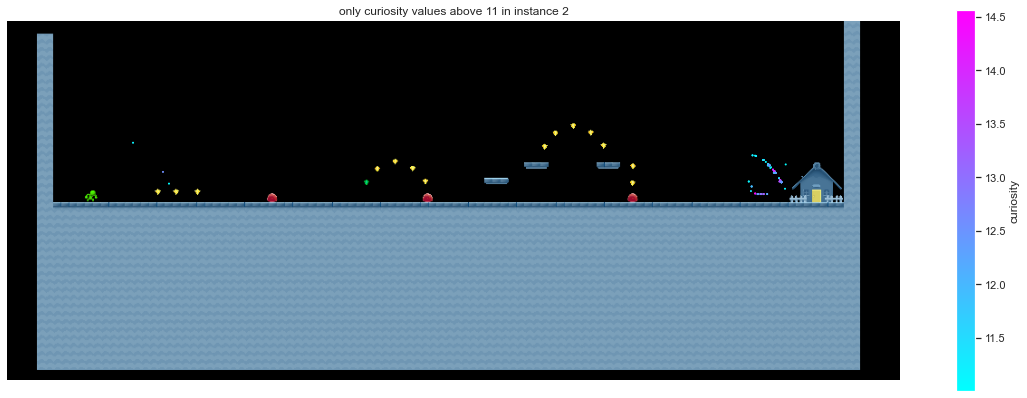

12


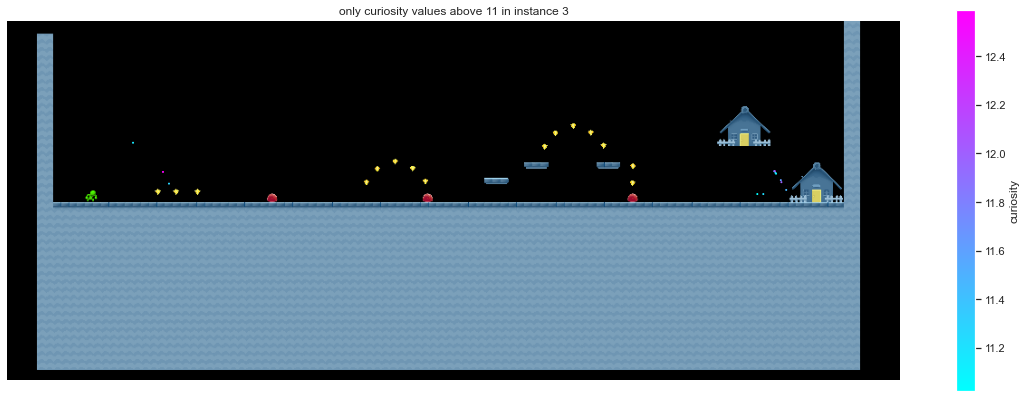

In [56]:
for i, df_instance in enumerate(dfs):
    df_hight_curiosity = df_instance[df_instance.curiosity > threshold]
    print(len(df_hight_curiosity))

    create_hight_curiosity_plot(df_hight_curiosity, f"instance {i}")
    plot_level(imgs[i])
    disable_grid_and_axis()
    plt.show()
    df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)

In [57]:
df_bugs = pd.read_json(str(data_folder + 'bug_locations.json'))

df_bugs_0 = df_bugs[df_bugs.InstanceId == 0]
df_bugs_1 = df_bugs[df_bugs.InstanceId == 1]
df_bugs_2 = df_bugs[df_bugs.InstanceId == 2]
df_bugs_3 = df_bugs[df_bugs.InstanceId == 3]

df_bugs_i = [df_bugs_0, df_bugs_1, df_bugs_2, df_bugs_3]

df_bugs

X         Y  Radius                   Name  InstanceId  Visible
0  23.840000  0.790000     0.5        TokenWrongColor           0     True
1   2.040001 -0.490000     0.5            NoAnimation           2     True
2  10.500000 -0.015465     0.5        TokenWrongColor           2     True
3   0.970001 -0.490000     0.5      TokenKillInstance           1    False
4  13.561996 -0.415465     0.5        WrongColorEnemy           1     True
5  29.490000  2.540001     2.0          HouseInTheAir           3     True
6  10.500000 -0.015465     0.5        TokenNoCollider           3    False
7  13.562000 -0.415465     0.5  EnemyReverseBehaviour           0    False

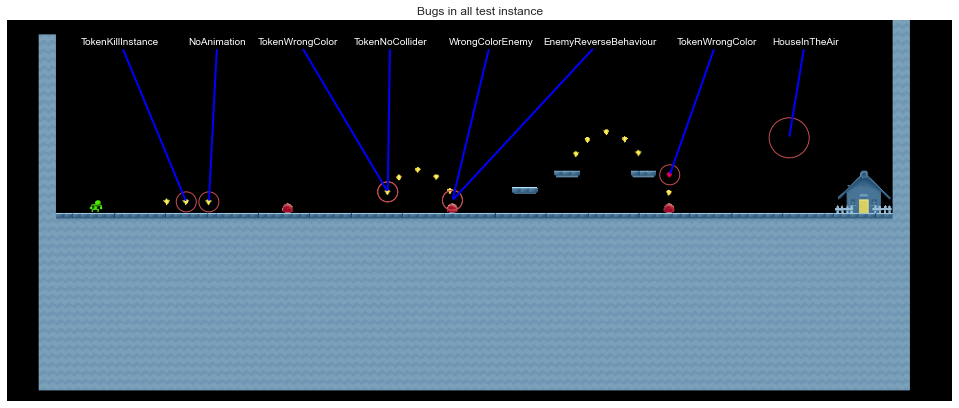

In [58]:
def annotate_bugs_plot(ax, names, xs, ys, char_size=0.3):
    x_text = xs[0] - 5
    for txt, x, y in zip(names, xs, ys):
    # for i, txt in enumerate(names):
        ax.annotate(txt, (x, y), xytext=[x_text, 7], color='white', arrowprops={'arrowstyle': '-', 'color': 'blue', 'lw': 2})
        x_text += len(txt)*char_size

def create_bugs_in_level_plot(data_frame: pd.DataFrame, name:str, ax: plt.Axes = None, char_size=0.3, figsize=(20,7)) -> plt.Axes:
    ax = data_frame.plot.scatter('X', 'Y', s=data_frame.Radius*800, figsize=figsize, title=f"Bugs in {name}", color='none', edgecolors='r', ax=ax)
    df_bugs_plot = data_frame.sort_values('X').reset_index()
    annotate_bugs_plot(ax, df_bugs_plot.Name, df_bugs_plot.X, df_bugs_plot.Y, char_size)
    # x_text = df_bugs_plot.X[0] - 5
    # for i, txt in enumerate(df_bugs_plot.Name):
    #     ax.annotate(txt, (df_bugs_plot.X[i], df_bugs_plot.Y[i]), xytext=[x_text, 7], color='white', arrowprops={'arrowstyle': '-', 'color': 'blue', 'lw': 2})
    #     x_text += len(txt)*0.3

    return ax

create_bugs_in_level_plot(df_bugs, 'all test instance')
plot_level(img0)
disable_grid_and_axis()
plt.savefig(str(log_folder + 'bugs_in_the_level.png'), dpi=300, bbox_inches='tight')
plt.show()

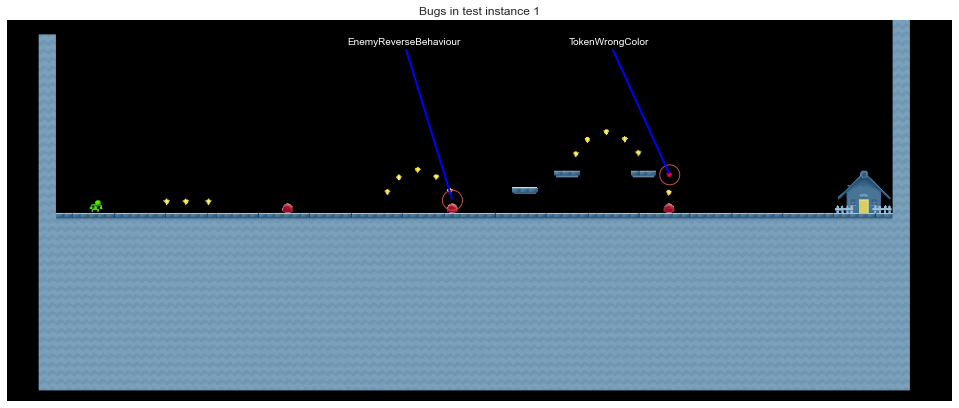

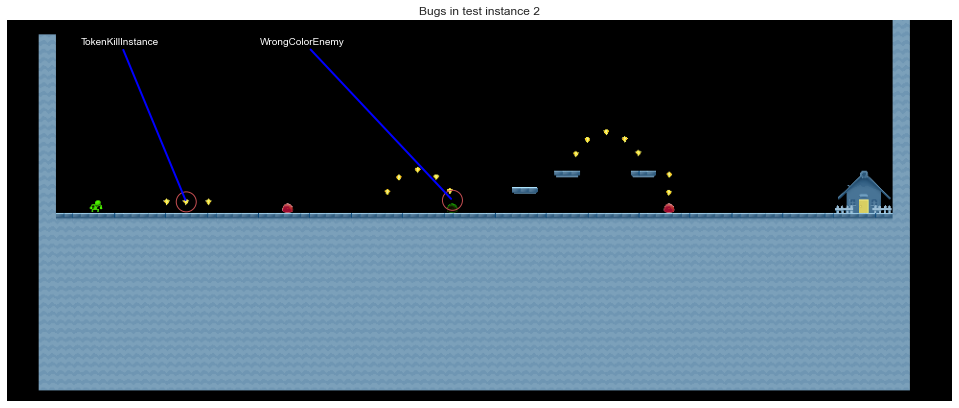

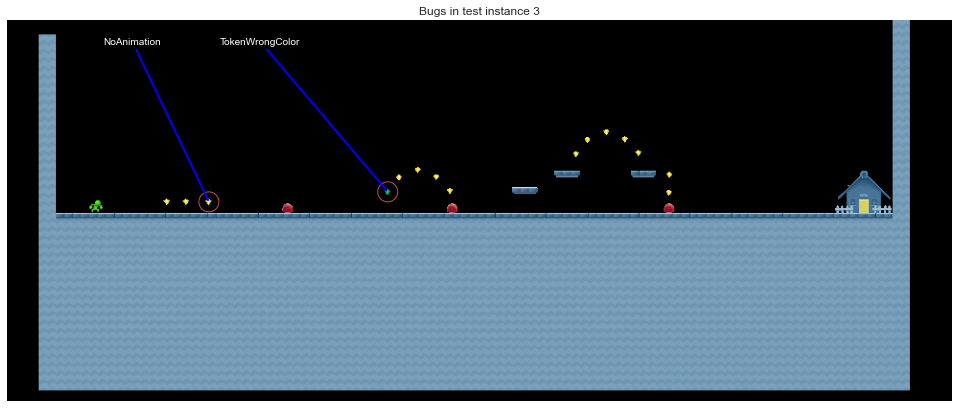

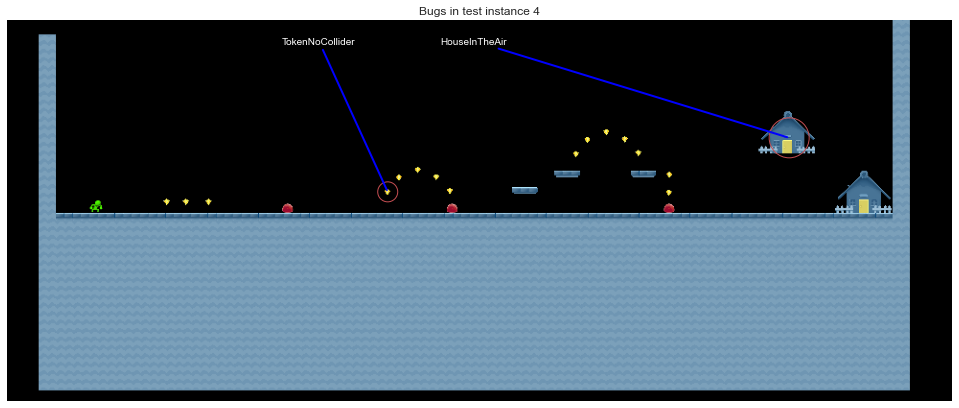

In [59]:
for i, df_bugs_instance in enumerate(df_bugs_i):
    create_bugs_in_level_plot(df_bugs_instance, f"test instance {i+1}", char_size=0.5)
    plot_level(imgs[i])
    disable_grid_and_axis()
    plt.savefig(str(log_folder + f"bugs_in_the_level_{i}.png"), dpi=300, bbox_inches='tight')
    plt.show()

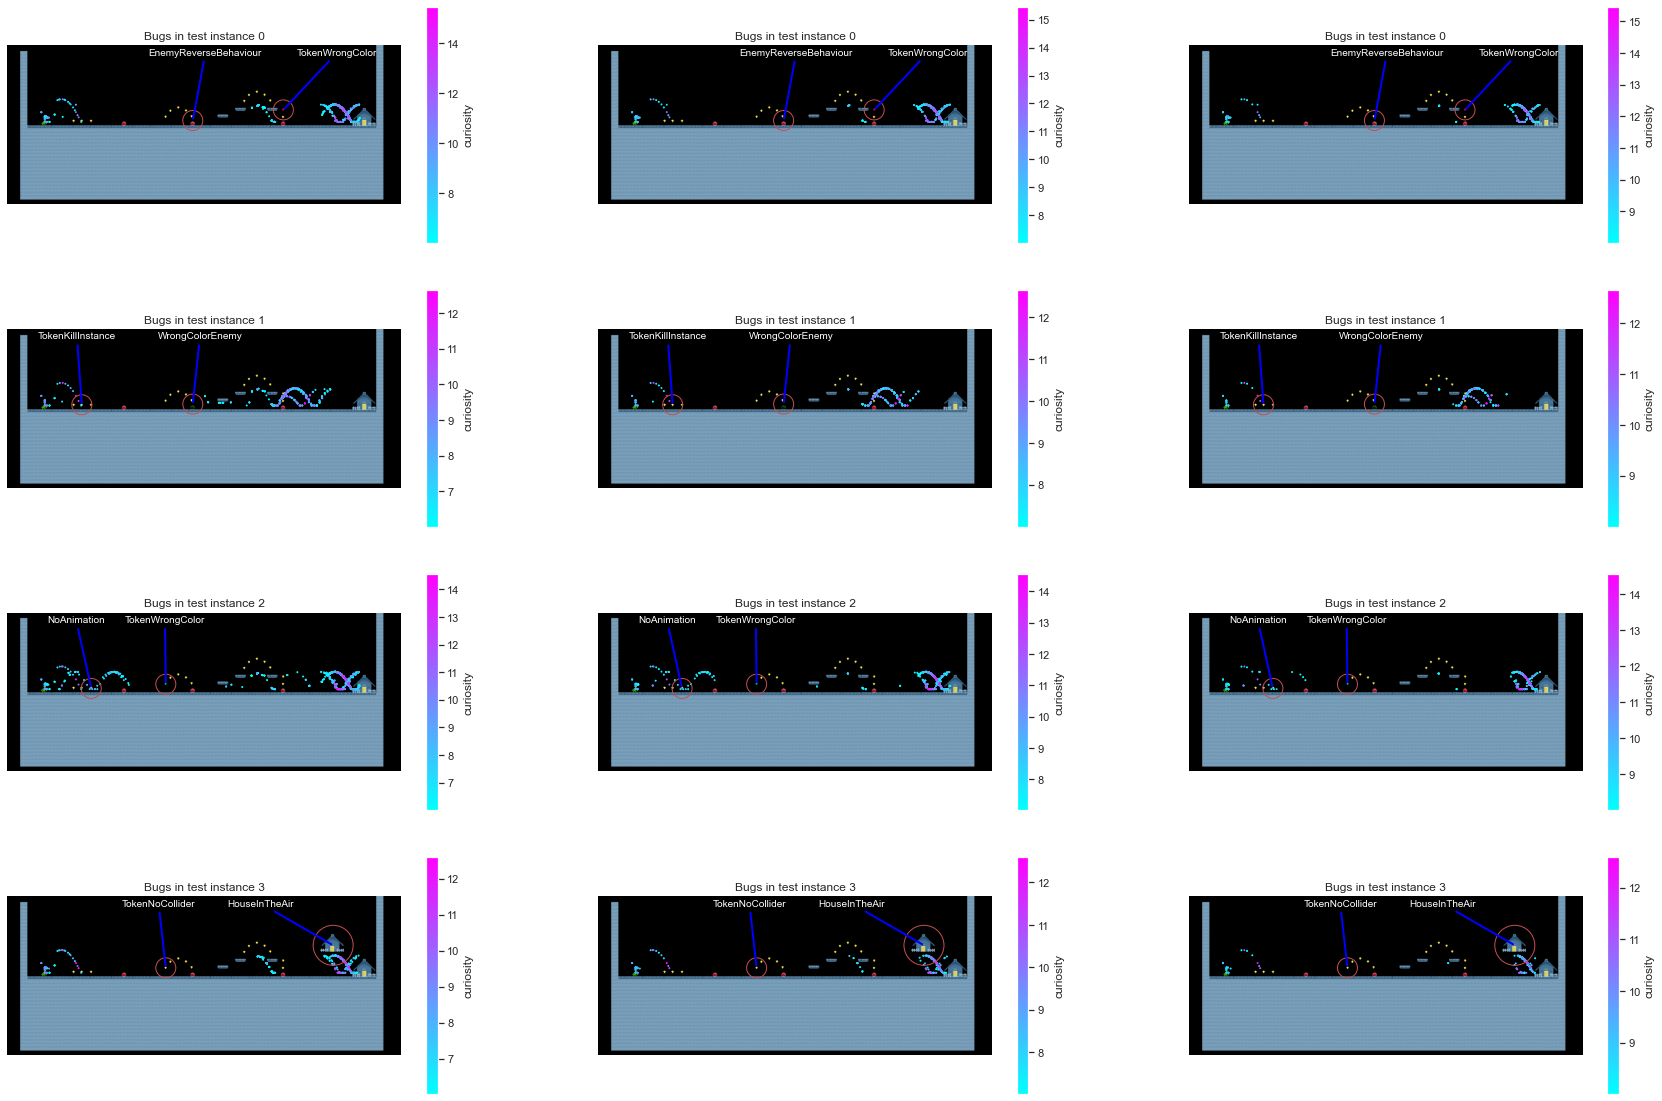

[6, 7, 8]


In [60]:
def plot_bugs_and_hight_curiosity(axs, threshold: float):
    for i, (df_instance, df_bugs_instance) in enumerate(zip(dfs, df_bugs_i)):
        df_hight_curiosity = df_instance[df_instance.curiosity > threshold]
        create_hight_curiosity_plot(df_hight_curiosity, f"instance {i}", axs[i], figsize=None)
        create_bugs_in_level_plot(df_bugs_instance, f"test instance {i}", axs[i], char_size=0.8, figsize=None)
        plot_level(imgs[i], axs[i])
        disable_grid_and_axis(axs[i])
        # plt.savefig(str(log_folder + f"best_curiosity_plot_{i}.png"), dpi=300, bbox_inches='tight')
        # plt.show()
        df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)
        # print(df_sorted)

thresholds = [6, 7, 8]

fig, axs = plt.subplots(nrows=4, ncols=len(thresholds), figsize=(30,20), clear=True)
for i, t in enumerate(thresholds):
    plot_bugs_and_hight_curiosity(axs[:, i], t)

plt.savefig(str(log_folder + f"best_curiosity_plot_{thresholds}.png"), dpi=300, bbox_inches='tight')
plt.show()

print(thresholds)

## Bugs found

In [61]:
def eval_bugs(threshold: float):
    true_positives = [[], [], [], []]
    false_positives = [[], [], [], []]
    bug_names = set()

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    camera_radius = 4

    for instance_id, df_instance in enumerate(dfs):
        df_instance_positiv = df_instance[df_instance.curiosity > threshold]
        df_instance_negative = df_instance[df_instance.curiosity <= threshold]
        for i, r_test in df_instance_positiv.iterrows():
            test_pos = np.array([r_test.x, r_test.y])
            is_real_bug = False
            for j, r_bugs in df_bugs_i[instance_id].iterrows():
                bug_pos = np.array([r_bugs.X, r_bugs.Y])
                dist = np.linalg.norm(bug_pos - test_pos)

                c_radius = camera_radius if r_bugs['Visible'] else 0
                if dist < r_bugs.Radius + c_radius:
                    if r_bugs.Name not in bug_names:
                        bug_names.add(r_bugs.Name)

                    bugs_dict = {'x': r_test.x, 'y': r_test.y, 'name': r_bugs.Name, 'curiosity': r_test.curiosity, 'instance_id': instance_id}
                    true_positives[instance_id].append(bugs_dict)
                    tp += 1
                    is_real_bug = True
            if not is_real_bug:
                fp += 1
                false_positives[instance_id].append(test_pos)

        for i, r_test in df_instance_negative.iterrows():
            test_pos = np.array([r_test.x, r_test.y])
            is_real_bug = False
            for j, r_bugs in df_bugs_i[instance_id].iterrows():
                bug_pos = np.array([r_bugs.X, r_bugs.Y])
                dist = np.linalg.norm(bug_pos - test_pos)

                c_radius = camera_radius if r_bugs['Visible'] else 0
                if dist < r_bugs.Radius + c_radius:
                    fn += 1
                    is_real_bug = True
            if not is_real_bug:
                tn += 1
                
    return true_positives, false_positives, tp, fp, tn, fn, bug_names

In [62]:
accuracys = []
precisions = []
recalls = []
f1s = []
thresholds = [8, 9, 10, 11, 12, 13]
tps = []
fps = []
tns = []
fns = []
all_bugs_found = []

for t in thresholds:
    true_positives, false_positives, tp, fp, tn, fn, bugs_found = eval_bugs(t)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = (2 * tp)/ (2 * tp + fp + fn)
    
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    all_bugs_found.append(len(bugs_found) / len(df_bugs))
    
    print('threshol', t)
    print('true positive', tp)
    print('false positive', fp)
    print('true negative', tn)
    print('false negative', fn)
    print('accuracy', accuracy)
    print('precision', precision)
    print('recall', recall)
    print('f1', f1)
    print('bugs_found', f"{len(bugs_found)} / {len(df_bugs)}")
    print('bugs_found_p', len(bugs_found) / len(df_bugs))
    print()

threshol 9
true positive 63
false positive 700
true negative 128020
false negative 55846
accuracy 0.6937317539498129
precision 0.08256880733944955
recall 0.001126831100538375
f1 0.002223320158102767
bugs_found 2 / 8
bugs_found_p 0.25

threshol 8
true positive 133
false positive 1136
true negative 127584
false negative 55776
accuracy 0.6917494001484057
precision 0.10480693459416864
recall 0.0023788656566921247
f1 0.004652138934555248
bugs_found 3 / 8
bugs_found_p 0.375

threshol 10
true positive 29
false positive 467
true negative 128253
false negative 55880
accuracy 0.6948095911259878
precision 0.05846774193548387
recall 0.0005187000304065536
f1 0.0010282776349614395
bugs_found 2 / 8
bugs_found_p 0.25

threshol 11
true positive 12
false positive 266
true negative 128454
false negative 55897
accuracy 0.6958061842939083
precision 0.04316546762589928
recall 0.00021463449534064283
f1 0.00042714506914410806
bugs_found 2 / 8
bugs_found_p 0.25

threshol 12
true positive 2
false positive 121
t

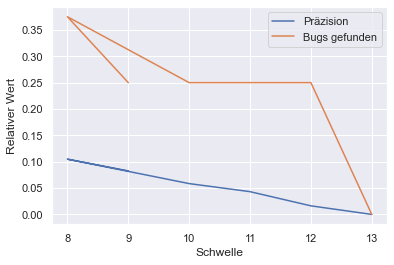

In [63]:
# plt.plot(thresholds, accuracys, label='accuracy')
plt.plot(thresholds, precisions, label='Präzision')
# plt.plot(thresholds, recalls, label='recall')
# plt.plot(thresholds, f1s, label='f1')
plt.plot(thresholds, all_bugs_found, label='Bugs gefunden')
plt.xlabel('Schwelle')
plt.ylabel('Relativer Wert')
plt.savefig(str(log_folder + f"threshold_analysis.png"), dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

In [64]:
threshold = 8
true_positives, false_positives, tp, fp, tn, fn, bugs_found = eval_bugs(threshold)

instance 0
true_positive 9
false_positive 419



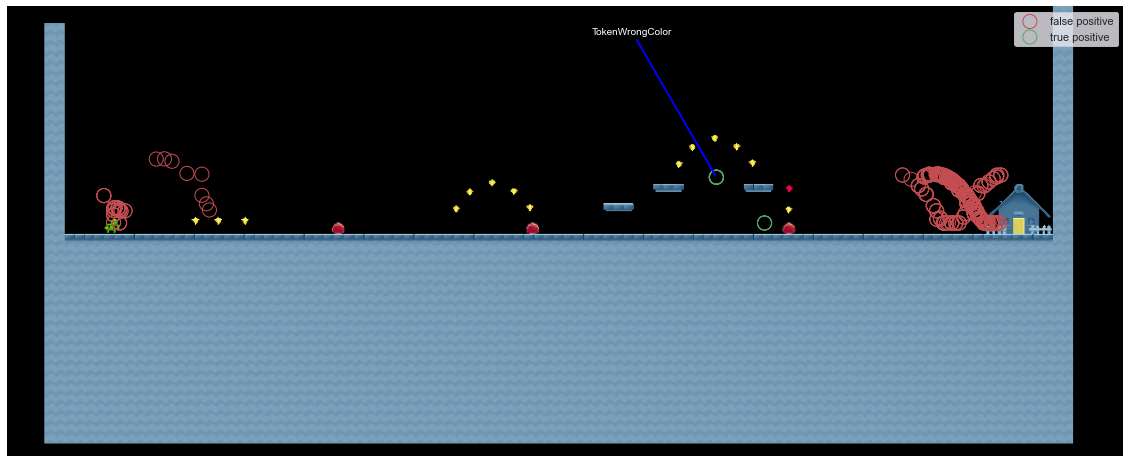

instance 1
true_positive 0
false_positive 226



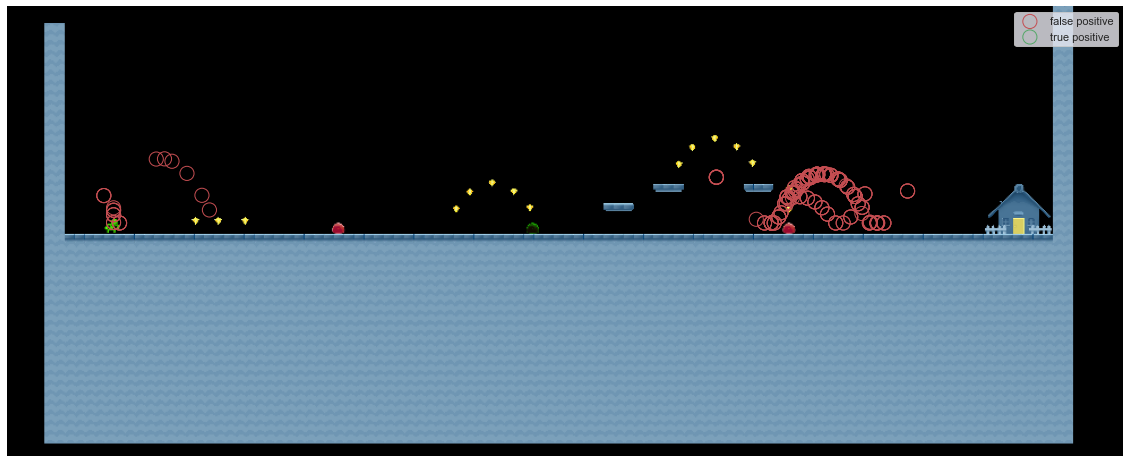

instance 2
true_positive 20
false_positive 463



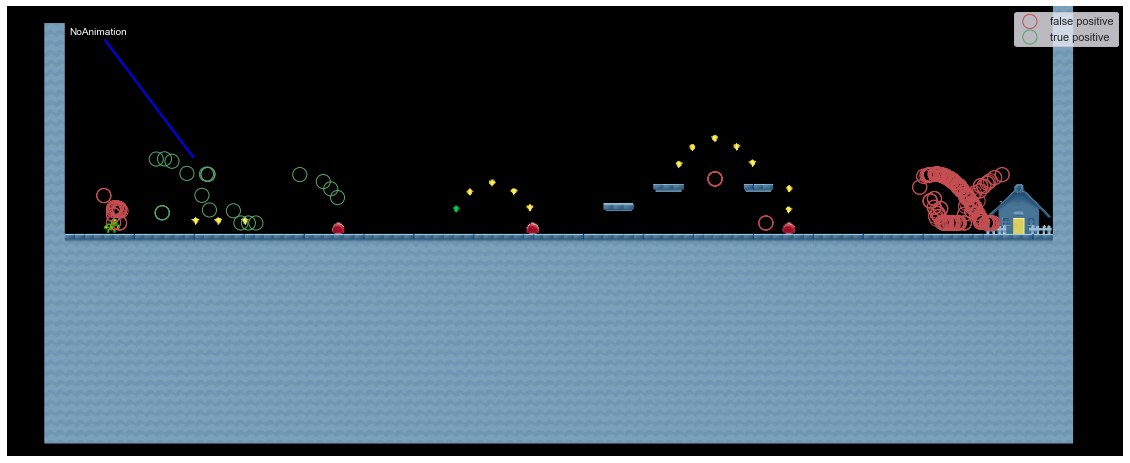

instance 3
true_positive 104
false_positive 28



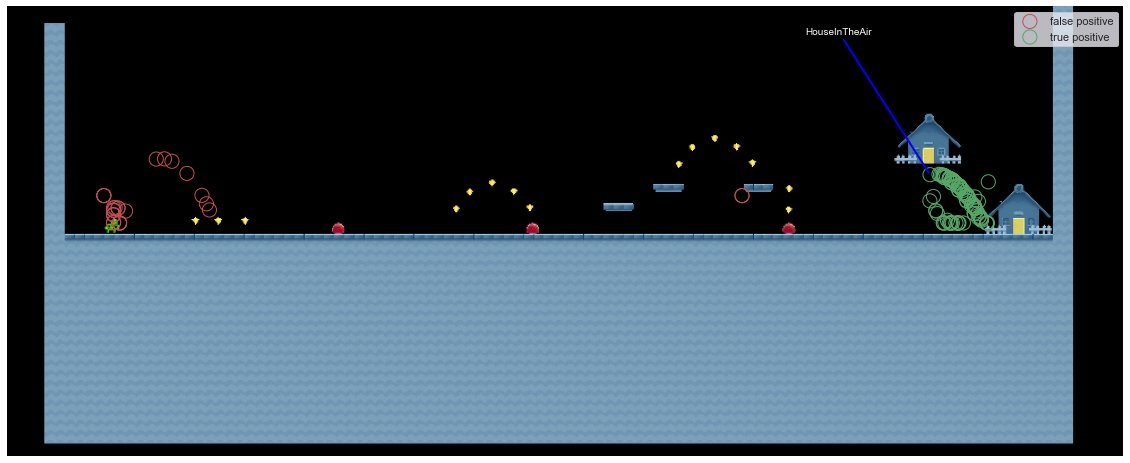

In [67]:
for j, (true_pos, false_pos) in enumerate(zip(true_positives, false_positives)):
    print(f"instance {j}")
    print('true_positive', len(true_pos))
    print('false_positive', len(false_pos))
    print()
    
    fig = plt.figure(figsize=(20, 10))
    x_false = np.array([row[0] for row in false_pos])
    y_false = np.array([row[1] for row in false_pos])
    plt.scatter(x_false, y_false, s=200, color='none', edgecolors='r', label="false positive")
    
    x = np.array([row['x'] for row in true_pos])
    y =  np.array([row['y'] for row in true_pos])
    names = np.array([row['name'] for row in true_pos])

    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    names = names[idx]

    names_set = set()

    plt.scatter(x, y, s=200, color='none', edgecolors='g', label="true positive")
    k = 0

    df_tmp = pd.DataFrame(data={'x': x, 'y': y, 'names': names})
    df_tmp = df_tmp.groupby(['names']).agg({'x': 'min', 'y': 'max'})
    df_tmp = df_tmp.clip(0)
    if(len(df_tmp) > 0):
        annotate_bugs_plot(fig.axes[0], df_tmp.index.tolist(), df_tmp.x.tolist(), df_tmp.y.tolist())

    plot_level(imgs[j])
    disable_grid_and_axis()
    # plt.title(f"Bugs found in instance {j} with curiosity > {threshold}")
    plt.legend()
    plt.savefig(str(log_folder + f"bugs_found_{j}.png"), dpi=300, bbox_inches='tight')
    plt.show()

threshol 13
true positive 133
false positive 1136
true negative 127584
false negative 55776
accuracy 0.6917494001484057
precision 0.10480693459416864
recall 0.0023788656566921247



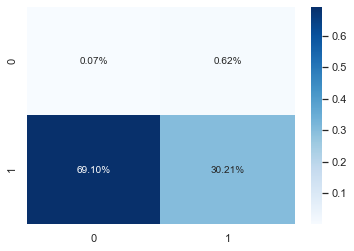

In [66]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('threshol', t)
print('true positive', tp)
print('false positive', fp)
print('true negative', tn)
print('false negative', fn)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)
print()

cf_matrix = np.array([
    [tp, fp], 
    [tn, fn]])
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(25,30), clear=True)
plot_bugs_and_hight_curiosity(axs.flatten(), threshold)
plt.savefig(str(log_folder + f"best_curiosity_plot_all.png"), dpi=300, bbox_inches='tight')
plt.show()